In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch

import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.datasets as dataset
import torchvision

from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from PIL import Image

import os
import numpy as np


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.model_selection import train_test_split

from torchvision import models
from torch.optim import lr_scheduler

In [2]:
!ls /home/ubuntu/fastai/courses/dl1/Isazi/Task1_China/data/resize/train/normal/ -l |wc -l
!ls /home/ubuntu/fastai/courses/dl1/Isazi/Task1_China/data/resize/train/abnormal/ -l |wc -l
!ls /home/ubuntu/fastai/courses/dl1/Isazi/Task1_China/data/resize/valid/normal/ -l |wc -l
!ls /home/ubuntu/fastai/courses/dl1/Isazi/Task1_China/data/resize/valid/abnormal/ -l |wc -l

325
316
83
80


In [3]:
f = os.listdir('/home/ubuntu/fastai/courses/dl1/Isazi/Task1_China/data/resize/train/normal/')

In [4]:
resize_path = '/home/ubuntu/fastai/courses/dl1/Isazi/Task1_China/data/resize/train/normal/'
os.path.join(resize_path, f[0])

'/home/ubuntu/fastai/courses/dl1/Isazi/Task1_China/data/resize/train/normal/CHNCXR_0235_0.png'

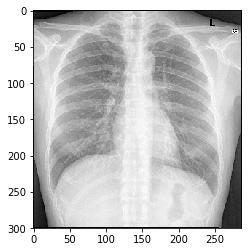

(300, 287, 3)

In [5]:
img = plt.imread(os.path.join(resize_path, f[0]))
plt.imshow(img)
plt.show()
img.shape

### Building models starts from here

In [6]:
# Hyper Parameters
num_epochs = 30
batch_size = 64
learning_rate = 0.001

In [7]:
# Data loading code
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(1,1)),
    transforms.RandomRotation(1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#for training
traindir ='/home/ubuntu/fastai/courses/dl1/Isazi/Task1_China/data/resize/train'
train = dataset.ImageFolder(traindir, transform_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=6)

In [8]:
transform_valid = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(1,1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
#for validation
valdir ='/home/ubuntu/fastai/courses/dl1/Isazi/Task1_China/data/resize/valid'
valid = dataset.ImageFolder(valdir, transform_valid)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False, num_workers=6)

In [9]:
train.class_to_idx

{'abnormal': 0, 'normal': 1}

In [10]:
train.classes

['abnormal', 'normal']

### Check data in data loader

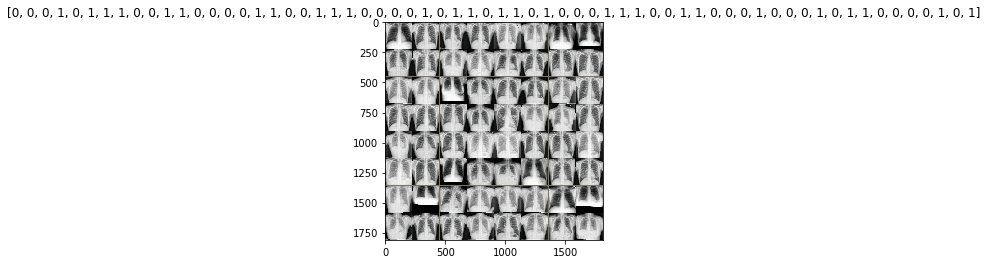

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x for x in classes])

In [12]:
inputs, classes = next(iter(train_loader))

In [13]:
inputs.size()

torch.Size([64, 3, 224, 224])

In [14]:
# inputs[0]

In [15]:
use_gpu = torch.cuda.is_available()
use_gpu

True

### Use Vgg model

In [16]:
model_vgg = models.vgg16(pretrained=True) #Load the vgg16 model with weigts.

In [17]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [18]:
for param in model_vgg.parameters():
#     print (param.shape)
#     print (param)
    param.requires_grad = False #freezing the whole network, requires_grad = False makes the layers non-learnable

In [19]:
model_vgg.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2)
        )

In [20]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [23]:
# model_vgg.classifier[6].out_features = 2

In [21]:
for param in model_vgg.classifier.parameters():
    print (param.shape)
    param.requires_grad = True  #make all the linear layer learnable

torch.Size([4096, 25088])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([2, 4096])
torch.Size([2])


In [22]:
print (torch.cuda.is_available())
use_gpu = torch.cuda.is_available()
if use_gpu:
    model_vgg = model_vgg.cuda() #shifting the model to gpu if available

True


### Change dropout

In [28]:
#model_vgg.classifier[5].p = 0.6 #probability of an element to be zero
#model_vgg.classifier[2].p = 0.6 #probability of an element to be zero

In [23]:
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer = torch.optim.Adam(model_vgg.classifier.parameters(), lr=0.001, weight_decay=0.1) ##Add regularization to prevent overfitting

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [26]:
%%time

best_train_acc = []
best_valid_acc = []
best_train_loss = []
best_valid_loss = []

for epoch in range(num_epochs):
    
#     exp_lr_scheduler.step() 
    
    ## Training the model
    model_vgg.train(True) #！！Set model to training mode 
    
    running_loss = 0.0
    n = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images = Variable(images).cuda()  #for gpu
        labels = Variable(labels).cuda()  #for gpu

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model_vgg(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        n += 1
    Train_loss = running_loss/n
    best_train_loss.append(Train_loss)
    
    
    ## Prediction on training set for every epoch
    model_vgg.train(False)  #！！Set model to evaluation mode
    
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = Variable(images).cuda()
        outputs = model_vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()  #labels type is torch.totensor; predicted is torch.cuda.totensor
    train_acc = 100 * correct / total
    best_train_acc.append(train_acc)
    

    ## Prediction on validation set for every epoch
    correct = 0
    total = 0
    running_loss = 0.0
    n = 0
    for data in valid_loader:
        images, labels = data
        outputs = model_vgg(Variable(images).cuda()) #for gpu)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()

        #validation loss
        loss = criterion(outputs, Variable(labels).cuda())
        running_loss += loss.data[0]
        n += 1    
    valid_loss = running_loss/n #valid loss
    valid_acc = 100 * correct / total # valid acc
    best_valid_acc.append(valid_acc)
    best_valid_loss.append(valid_loss)
        
    print ('Epoch %d -- Train Loss: %.3f, Valid Loss: %.3f' %(epoch+1, Train_loss,valid_loss ))
    print ('Epoch %d -- Train Acc: %.2f %%, Valid Acc: %.2f %%' %(epoch+1, train_acc,valid_acc ))
    print ('---------------------------')
print ('Best trainging accuracy: %.2f %%' % (max(best_train_acc))) 
print ('Best validation accuracy: %.2f %%' % (max(best_valid_acc))) 
    
print('Finished Training')

Epoch 1 -- Train Loss: 0.559, Valid Loss: 0.395
Epoch 1 -- Train Acc: 79.66 %, Valid Acc: 80.75 %
---------------------------
Epoch 2 -- Train Loss: 0.449, Valid Loss: 0.371
Epoch 2 -- Train Acc: 84.51 %, Valid Acc: 81.99 %
---------------------------
Epoch 3 -- Train Loss: 0.363, Valid Loss: 0.425
Epoch 3 -- Train Acc: 86.54 %, Valid Acc: 83.85 %
---------------------------
Epoch 4 -- Train Loss: 0.394, Valid Loss: 0.330
Epoch 4 -- Train Acc: 89.51 %, Valid Acc: 86.34 %
---------------------------
Epoch 5 -- Train Loss: 0.408, Valid Loss: 0.337
Epoch 5 -- Train Acc: 89.51 %, Valid Acc: 87.58 %
---------------------------
Epoch 6 -- Train Loss: 0.408, Valid Loss: 0.398
Epoch 6 -- Train Acc: 89.36 %, Valid Acc: 85.09 %
---------------------------
Epoch 7 -- Train Loss: 0.361, Valid Loss: 0.518
Epoch 7 -- Train Acc: 84.04 %, Valid Acc: 77.64 %
---------------------------
Epoch 8 -- Train Loss: 0.391, Valid Loss: 0.411
Epoch 8 -- Train Acc: 90.45 %, Valid Acc: 85.71 %
--------------------

In [27]:
import matplotlib.pyplot as plt

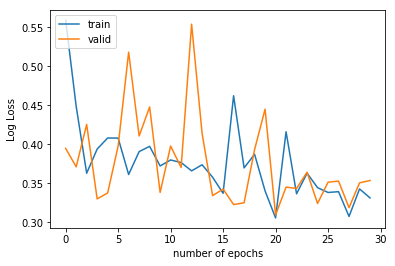

In [28]:
plt.plot(best_train_loss, label = 'train')
plt.plot(best_valid_loss, label = 'valid')
plt.legend(loc = 'upper left')
plt.xlabel("number of epochs")
plt.ylabel("Log Loss")
plt.show()

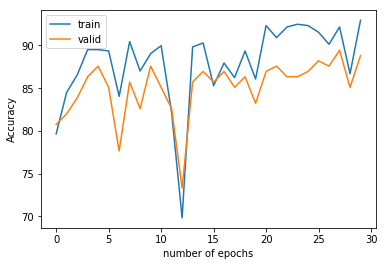

In [29]:
plt.plot(best_train_acc, label = 'train')
plt.plot(best_valid_acc, label = 'valid')
plt.legend(loc = 'upper left')
plt.xlabel("number of epochs")
plt.ylabel("Accuracy")
plt.show()

### Transfer learning